### Modelo Machine Learning Final

Importamos lo necesario

In [2]:
import warnings
import re
import pandas as pd
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pyarrow as pa
import pyarrow.parquet as pq
import seaborn as sns
import json
import datetime
import os
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

Filtramos los datos para centrarnos en nuestro cliente, pizzerías de Florida

In [3]:
###DataFrame Business
#lectura del archivo business.parquet
# Lectura del archivo business.parquet
df_business = pd.read_parquet('../0_Dataset/Data_Sucia/Yelp/business.parquet')

df_business = df_business.loc[:, ~df_business.columns.duplicated()]
df_business = df_business.dropna(subset=['categories'])
df_restaurantes = df_business[df_business['categories'].str.lower().str.contains('restaurant')].reset_index(drop=True)

# Fijamos los límites de latitud y longitud para filtrar los restaurantes en Florida
latitud_max = 31.0
latitud_min = 24.5
longitud_max = -80.0
longitud_min = -87.6


# Se establecen las mascaras para filtrar el df
mascara_latitud = (df_restaurantes['latitude'] >= latitud_min) & (df_restaurantes['latitude'] <= latitud_max)
mascara_longitud = (df_restaurantes['longitude'] >= longitud_min) & (df_restaurantes['longitude'] <= longitud_max)

# Se filtra el dataframe:
df_restaurantes_FL = df_restaurantes[mascara_latitud & mascara_longitud]
df_restaurantes_FL = df_restaurantes_FL.reset_index(drop=True)

# Se filtra por negocios abiertos y se elimina la columna que lo representa
df_restaurantes_FL = df_restaurantes_FL[df_restaurantes_FL['is_open'] == 1].reset_index(drop=True)
df_restaurantes_FL.drop(columns=['is_open','state'], inplace=True)

# Definimos las categorías de interés
categorias_interes = ['Pizza', 'Mexican']

# Convertir la columna 'categories' a minúsculas y realizar la búsqueda para cada palabra clave
condiciones = [df_restaurantes_FL['categories'].apply(lambda x: palabra.lower() in x.lower()) for palabra in categorias_interes]

# Aplicar la lógica OR a las condiciones para obtener el DataFrame filtrado
df_restaurantes_FL = df_restaurantes_FL[pd.concat(condiciones, axis=1).any(axis=1)]

# Simplificamos la columna 'categories' para reflejar solo 'Pizza' o 'Mexican'
df_restaurantes_FL['categories'] = df_restaurantes_FL['categories'].apply(lambda x: 'Pizza' if 'Pizza' in x else 'Mexican')

# Eliminamos las columnas especificadas del DataFrame
drop_columns = ['postal_code', 'attributes', 'hours']
df_restaurantes_FL = df_restaurantes_FL.drop(columns=drop_columns)

# Definimos los IDs únicos de business para usarlos posteriormente en el DataFrame de review
negocios_unicos = df_restaurantes_FL['business_id'].unique().tolist()


print(df_restaurantes_FL)

                 business_id                           name  \
4     aNtKyc2rr-uK5cqzY9TVQQ         Chipotle Mexican Grill   
13    XwoXi0M66RU6Gouq-DSDHw       G Peppers Grill & Tavern   
14    j9Kaj_6tSeXmVMYCgZithg                    Noble Crust   
15    EIlFs8kybcG-l60GJjNUIA                 Domino's Pizza   
23    uKEabBQrn0gLzvTppOrKIA                Casita Taqueria   
...                      ...                            ...   
5911  0a9Miij7BFmKm83Iqni5sA                  Capital Tacos   
5913  TaWCKl6hVCwm2ksdRBIJSQ                          Cicis   
5915  s2eyoTuJrcP7I_XyjdhUHQ                  Bros Pizzeria   
5916  iI6S-dv31iV2I16UuXTnPA              Rudy's Sports Bar   
5920  esBGrrmuZzSiECyRBoKvvA  Colony Grill - St. Petersburg   

                       address              city   latitude  longitude  stars  \
4            10160 Ulmerton Rd             Largo  27.894167 -82.779866    3.0   
13               8745 Gunn Hwy            Odessa  28.092136 -82.578574    4.0   


Confirmamos el error en la carga de los datos para la columna City

In [4]:
df_restaurantes_FL['city'].unique()

array(['Largo', 'Odessa', 'Wesley Chapel', 'Oldsmar', 'Saint Petersburg',
       'St Petersburg', 'Tampa', 'Palm Harbor', 'Pinellas Park',
       'Spring Hill', "Land O' Lakes", 'Clearwater Beach', 'Clearwater',
       'Gulfport', 'St. Petersburg', 'Holiday', 'Lutz', 'Valrico',
       'Wimauma', 'Hudson', 'New Port Richey', 'Riverview', 'Trinity',
       'Dunedin', 'Brandon', 'Plant City', 'Tampa Bay', 'Madeira Beach',
       'Port Richey', 'Indian Rocks Beach', 'Ruskin', 'Seminole', 'Dover',
       'Tarpon Springs', 'Seffner', 'Temple Terrace', 'Zephyrhills',
       'St Pete Beach', 'Apollo Beach', 'Sun City Center', 'Kenneth City',
       'St. Pete Beach', 'Pinecrest West Park', 'Tierra Verde',
       'Saintt Petersburg', 'South Pasadena', 'Land O Lakes',
       'Safety Harbor', 'Gibsonton', 'Lithia', 'North Redington Beach',
       'Indian Shores', 'Wesley chapel', 'Saint Pete Beach',
       'Belleair Bluffs', 'Lutz fl', 'Redingtn Shor', 'Dade City',
       'wimauma', 'Palmetto', 'L

Corregimos los nombres de las ciudades

In [5]:
# Definir las correcciones para los nombres de las ciudades
city_corrections = {
    'Saint Petersburg': 'St. Petersburg',
    'St Petersburg': 'St. Petersburg',
    'St Pete Beach': 'St. Pete Beach',
    'Saintt Petersburg': 'St. Petersburg',
    'Saint Pete Beach': 'St. Pete Beach',
    'Land O Lakes': 'Land O\' Lakes',
    'Wesley chapel': 'Wesley Chapel',
    'Lutz fl': 'Lutz',
    'Redingtn Shor': 'Redington Shores',
    'TEMPLE TERR': 'Temple Terrace',
    'Hernando Bch': 'Hernando Beach',
    'wimauma': 'Wimauma',
    'Largo (Walsingham)': 'Key Largo',
    'Largo': 'Key Largo',
    'Town N Country': 'Town \'n\' Country',
    'Town \'N\' Country': 'Town \'n\' Country',
    'Tampa Bay': 'Tampa',
    'Clearwater Beach': 'Clearwater',
    'Clearwater beach': 'Clearwater',
    'Pinecrest West Park': 'Pinecrest'
}

# Aplicar las correcciones al DataFrame
df_restaurantes_FL['city'] = df_restaurantes_FL['city'].replace(city_corrections)

# Verificar los valores únicos de las ciudades después de las correcciones
df_restaurantes_FL['city'].unique()

array(['Key Largo', 'Odessa', 'Wesley Chapel', 'Oldsmar',
       'St. Petersburg', 'Tampa', 'Palm Harbor', 'Pinellas Park',
       'Spring Hill', "Land O' Lakes", 'Clearwater', 'Gulfport',
       'Holiday', 'Lutz', 'Valrico', 'Wimauma', 'Hudson',
       'New Port Richey', 'Riverview', 'Trinity', 'Dunedin', 'Brandon',
       'Plant City', 'Madeira Beach', 'Port Richey', 'Indian Rocks Beach',
       'Ruskin', 'Seminole', 'Dover', 'Tarpon Springs', 'Seffner',
       'Temple Terrace', 'Zephyrhills', 'St. Pete Beach', 'Apollo Beach',
       'Sun City Center', 'Kenneth City', 'Pinecrest', 'Tierra Verde',
       'South Pasadena', 'Safety Harbor', 'Gibsonton', 'Lithia',
       'North Redington Beach', 'Indian Shores', 'Belleair Bluffs',
       'Redington Shores', 'Dade City', 'Palmetto', 'Treasure Island',
       'Citrus Park', "Town 'n' Country", 'San Antonio', 'Thonotosassa',
       'Hernando Beach'], dtype=object)

Quedó listo nuestro dataframe de restaurantes. El mismo contiene la siguiente información:
1. business_id: Identificador de los negocios.
2. name: Nombre de los negocios.
3. address: Ubicación por calle de los negocios.
4. city: Ciudad donde se encuentran los negocios (Dentro de Florida)
5. latitude: Latitud de la ubicación del negocio.
6. longitude: Longitud de la ubicación del negocio.
7. stars: Estrellas totales del negocio.
8. review_count: Cantidad de reseñas totales del negocio.
9. categories: Categoría del negocio (Pizza o Mexican)

In [6]:
# Carga el archivo parquet en un dataframe de pandas
df = pd.read_parquet('../0_Dataset/Data_Sucia/Yelp/review_FL_reducido.parquet')

# Se determina la cantidad de datos por porción:
chunk_size = 50000

# Se divide el dataframe en trozos
chunks = [df[i:i+chunk_size] for i in range(0, df.shape[0], chunk_size)]

# Se crea una lista vacía donde se almacenarán los distintos dataframes
dfs = []
for chunk in chunks:
    dfs.append(chunk)

# Se define el punto de corte para separar al dataframe en 2:
corte = int(len(dfs) / 2)

# Se define la primera mitad del dataframe:
dfs1 = dfs[:corte]
df_reviews1 = pd.concat(dfs1, axis=0, ignore_index=True)

yelp_rev = df_reviews1[df_reviews1["business_id"].isin(negocios_unicos)]

yelp_rev = yelp_rev.drop(columns=["useful", "funny", "cool"]).reset_index(drop=True)

# Se define la segunda mitad del dataframe
dfs2 = dfs[corte:]
df_reviews2 = pd.concat(dfs2, axis=0, ignore_index=True)

yelp_rev2 = df_reviews2[df_reviews2["business_id"].isin(negocios_unicos)]

yelp_rev2 = yelp_rev2.drop(columns=["useful", "funny", "cool"]).reset_index(drop=True)

yelp_rev = pd.concat([yelp_rev, yelp_rev2], axis=0, ignore_index=True)

# Asegúrate de que la columna 'date' esté en el tipo de dato correcto
yelp_rev["date"] = pd.to_datetime(yelp_rev["date"]).dt.date

print(yelp_rev)


                   review_id                 user_id             business_id  \
0     sCE2XujXG_mZTG0Tyt-EAQ  xBhlWj70SABdU6N0cGI0Qg  ovLgaPIMrx7PDZPrEpTMvg   
1     qcVMw4MUx3j8nVYz37-FOA  DZCbDA4bYT70nPgtL-ojjA  xJIeT5--AiPdvPb5BRflyQ   
2     b9I7_AKw_CmmJoLeaKfm9Q  mJonShqOoqWH0yqWVekr0A  sWCCxY1-9B1FGlSVeQvnHg   
3     AJPOltMO5J1-r69ca8Pitw  lX5Nlne7K-gwM2o56VudcA  3yI-7C8JzbG-ZaSqAGHMAQ   
4     9tULj7NTeO5JiNRvy_S3Qg  kA7sIBVKgWXVwWbpXsUHQg  9ouyziwYpSvJzlLFpukSgA   
...                      ...                     ...                     ...   
3754  8ScaTJoFOeCKjUEirXkBuQ  Sp2GV7D-_JLZMPQmDanzPQ  ZB61gANpKABguPC7kG6bzA   
3755  Gfaa3ivtvezj6qBbcCPHEA  y1jliVJq4GvwaXrTkL39vw  3Z4rhPFO6XWJRQipEIZCWA   
3756  EkpjFHMPVso7WYkZBVg1OA  6b5a-1EHCQs71IEsNiaZNw  isRg8RrE1iIv1ks27A1FuA   
3757  YE_ZDHfpO1KLm21v3-iIqQ  uzJoazpDpZanfCRFTXJmJg  FETeDc9sbYsPmHxT0qSVIg   
3758  sVqCLsQazlIDAJZRgpiw-Q  -l7PcahkxFRZrXe6IJ1l6A  RjTT7tn9BPTfRmyJagMN6g   

      stars                            

Quedó listo nuestro dataframe de reseñas. El mismo contiene la siguiente información:

1. review_id: Identificador de la reseña.
2. user_id: Nombre del reseñador.
3. business_id: Identificador del negocio (Coincide con df_restaurantes_FL).
4. stars: Estrellas totales del negocio.
8. text: Reseña completa.
9. date: Fecha de la reseña.

Ahora, uniremos los dataframes según su business ID para realizar un EDA

In [7]:
# Unir los datasets por business_id
df_combinado = yelp_rev.merge(df_restaurantes_FL, on='business_id', how='inner')

# Mostrar una muestra del dataframe combinado para verificar
print(df_combinado.head())

                review_id                 user_id             business_id  \
0  sCE2XujXG_mZTG0Tyt-EAQ  xBhlWj70SABdU6N0cGI0Qg  ovLgaPIMrx7PDZPrEpTMvg   
1  qcVMw4MUx3j8nVYz37-FOA  DZCbDA4bYT70nPgtL-ojjA  xJIeT5--AiPdvPb5BRflyQ   
2  b9I7_AKw_CmmJoLeaKfm9Q  mJonShqOoqWH0yqWVekr0A  sWCCxY1-9B1FGlSVeQvnHg   
3  AJPOltMO5J1-r69ca8Pitw  lX5Nlne7K-gwM2o56VudcA  3yI-7C8JzbG-ZaSqAGHMAQ   
4  9tULj7NTeO5JiNRvy_S3Qg  kA7sIBVKgWXVwWbpXsUHQg  9ouyziwYpSvJzlLFpukSgA   

   stars_x                                               text        date  \
0        5  Good pizza! U can get different taste in here....  2014-03-01   
1        4  Been here many times now since moving to Apoll...  2016-01-30   
2        1  People say "lightning only strikes once".  Wel...  2018-08-23   
3        5  Very tasty and fresh ! Love their salsas and t...  2016-03-19   
4        4  I mean, how can you NOT like chipotle? \n\nLoc...  2014-04-02   

                     name            address            city   latitude  \

Ahora, realizaremos un Análisis de Sentimiento a las reseñas ya filtradas.

In [8]:
from textblob import TextBlob

# Función para obtener el sentimiento
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# Aplicar la función de sentimiento a cada reseña
df_combinado['polarity'], df_combinado['subjectivity'] = zip(*df_combinado['text'].apply(get_sentiment))

# Ver los resultados
print(df_combinado[['text', 'polarity', 'subjectivity']].head())


                                                text  polarity  subjectivity
0  Good pizza! U can get different taste in here....  0.525000      0.600000
1  Been here many times now since moving to Apoll...  0.187500      0.470000
2  People say "lightning only strikes once".  Wel...  0.113636      0.630455
3  Very tasty and fresh ! Love their salsas and t...  0.311942      0.636777
4  I mean, how can you NOT like chipotle? \n\nLoc...  0.348810      0.662500


Ahora, a través de un aprendizaje no supervisado, categorizaremos estas reseñas según qué critican. Para ello, debemos pre-procesar el texto.

In [9]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

df_combinado['cleaned_text'] = df_combinado['text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\loren\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\loren\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Ahora, utilizaremos la función vectorización de SKLEARN para lograr una representación numérica

In [10]:
# Ejemplo de DataFrame etiquetado manualmente
data = {
    'text': [
        "The pizza was great, loved the crust and toppings.",
        "The waiter was very rude and inattentive.",
        "The restaurant has a cozy atmosphere with nice decor.",
        "The prices are too high for the quality of food."
    ],
    'category': ['comida', 'atencion', 'local', 'precio']
}

df_labeled = pd.DataFrame(data)
df_labeled['cleaned_text'] = df_labeled['text'].apply(preprocess_text)


Ahora sí, las categorizaremos.

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=1000)
X_labeled = tfidf.fit_transform(df_labeled['cleaned_text']).toarray()
y_labeled = df_labeled['category']

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42)

# Entrenar el modelo
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Evaluar el modelo
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    atencion       0.00      0.00      0.00       1.0
      comida       0.00      0.00      0.00       0.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0



In [13]:
# Vectorizar las reseñas no etiquetadas
X_unlabeled = tfidf.transform(df_combinado['cleaned_text']).toarray()

# Predecir las categorías
df_combinado['predicted_category'] = classifier.predict(X_unlabeled)

# Mostrar algunas predicciones
print(df_combinado[['text', 'predicted_category']].head())

                                                text predicted_category
0  Good pizza! U can get different taste in here....             precio
1  Been here many times now since moving to Apoll...             comida
2  People say "lightning only strikes once".  Wel...             comida
3  Very tasty and fresh ! Love their salsas and t...              local
4  I mean, how can you NOT like chipotle? \n\nLoc...             comida


In [14]:
import folium
from ipywidgets import interact, widgets
from IPython.display import display

# Función para crear el mapa
def create_map(city, category, rating_type):
    # Filtrar los datos según la ciudad y la categoría seleccionadas
    df_filtered = df_combinado[(df_combinado['city'] == city) & (df_combinado['categories'].str.contains(category))]
    
    # Ordenar y seleccionar los top 5 según el tipo de rating seleccionado
    if rating_type == 'Top 5 mejores ratings':
        df_filtered = df_filtered.sort_values(by='stars_x', ascending=False).head(5)
    elif rating_type == 'Bottom 5 peores ratings':
        df_filtered = df_filtered.sort_values(by='stars_x').head(5)
    
    # Crear un mapa centrado en la ciudad seleccionada
    city_location = [df_filtered['latitude'].mean(), df_filtered['longitude'].mean()]
    m = folium.Map(location=city_location, zoom_start=10)
    
    # Agregar marcadores para cada restaurante
    for _, row in df_filtered.iterrows():
        popup_text = f"""
        Name: {row['name']}<br>
        Address: {row['address']}<br>
        Rating: {row['stars_x']}<br>
        Cluster: {row['predicted_category']}
        """
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=popup_text,
            icon=folium.Icon(color='red' if row['stars_x'] < 3 else 'green')
        ).add_to(m)
    
    return m

# Crear widgets interactivos
city_widget = widgets.Dropdown(
    options=df_combinado['city'].unique(),
    description='City:'
)

category_widget = widgets.Dropdown(
    options=['Pizza', 'Mexican'],
    description='Category:'
)

rating_widget = widgets.Dropdown(
    options=['Top 5 mejores ratings', 'Bottom 5 peores ratings'],
    description='Rating:'
)

# Función para actualizar el mapa
def update_map(city, category, rating_type):
    display(create_map(city, category, rating_type))

# Mostrar los widgets y el mapa interactivo
interact(update_map, city=city_widget, category=category_widget, rating_type=rating_widget)


interactive(children=(Dropdown(description='City:', options=('Tampa', 'Riverview', 'St. Petersburg', 'Pinellas…

<function __main__.update_map(city, category, rating_type)>

In [15]:
# Guardar el DataFrame df_combinado en formato parquet
df_combinado.to_parquet('df_combinado.parquet')


In [16]:
# Distribución de calificaciones
df_calificaciones = df_combinado.groupby('name')['stars_x'].describe()

# Mostrar una muestra del dataframe de distribución de calificaciones
print(df_calificaciones.head())


                                  count      mean       std  min   25%  50%  \
name                                                                          
1000 Degrees Neapolitan Pizzeria    2.0  4.500000  0.707107  4.0  4.25  4.5   
4th Street Pizza                    3.0  2.000000  1.000000  1.0  1.50  2.0   
82 Degrees                          3.0  5.000000  0.000000  5.0  5.00  5.0   
900 Degrees Woodfired Pizza         9.0  3.222222  1.641476  1.0  2.00  3.0   
A Slice of Rome                     1.0  5.000000       NaN  5.0  5.00  5.0   

                                   75%  max  
name                                         
1000 Degrees Neapolitan Pizzeria  4.75  5.0  
4th Street Pizza                  2.50  3.0  
82 Degrees                        5.00  5.0  
900 Degrees Woodfired Pizza       5.00  5.0  
A Slice of Rome                   5.00  5.0  


In [17]:
# Número de reseñas por negocio
df_numero_reseñas = df_combinado.groupby('name')['review_id'].count().reset_index()
df_numero_reseñas.columns = ['name', 'num_reviews']

# Mostrar una muestra del dataframe de número de reseñas
print(df_numero_reseñas.head())


                               name  num_reviews
0  1000 Degrees Neapolitan Pizzeria            2
1                  4th Street Pizza            3
2                        82 Degrees            3
3       900 Degrees Woodfired Pizza            9
4                   A Slice of Rome            1


In [18]:
# Promedio de calificaciones por negocio
df_promedio_calificaciones = df_combinado.groupby('name')['stars_x'].mean().reset_index()
df_promedio_calificaciones.columns = ['name', 'average_stars']

# Mostrar una muestra del dataframe de promedio de calificaciones
print(df_promedio_calificaciones.head())


                               name  average_stars
0  1000 Degrees Neapolitan Pizzeria       4.500000
1                  4th Street Pizza       2.000000
2                        82 Degrees       5.000000
3       900 Degrees Woodfired Pizza       3.222222
4                   A Slice of Rome       5.000000


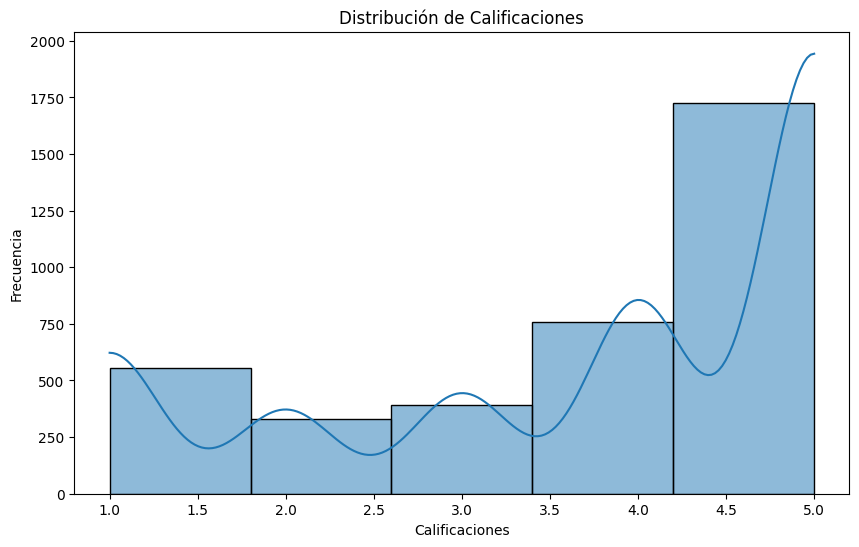

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(df_combinado['stars_x'], bins=5, kde=True)
plt.title('Distribución de Calificaciones')
plt.xlabel('Calificaciones')
plt.ylabel('Frecuencia')
plt.show()

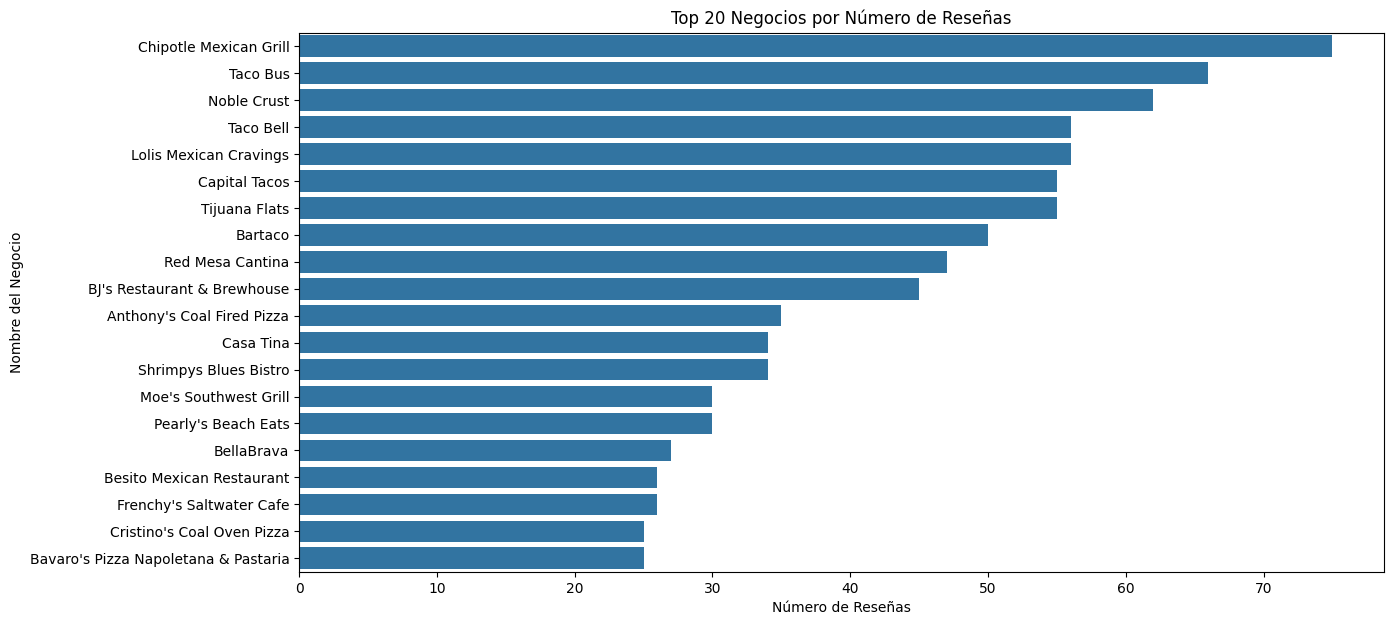

In [20]:
plt.figure(figsize=(14, 7))
sns.barplot(x='num_reviews', y='name', data=df_numero_reseñas.sort_values(by='num_reviews', ascending=False).head(20))
plt.title('Top 20 Negocios por Número de Reseñas')
plt.xlabel('Número de Reseñas')
plt.ylabel('Nombre del Negocio')
plt.show()


Ahora, veremos la tasa de crecimiento de estos restaurantes

In [21]:
# Paso 1: Extraer el año de la columna `date`
df_combinado['year'] = pd.DatetimeIndex(df_combinado['date']).year

# Paso 2: Agrupar las reseñas por año
df_reviews_by_year = df_combinado.groupby(['business_id', 'year']).size().reset_index(name='num_reviews')

# Paso 3: Ya calculamos el número de reseñas por año en el paso anterior

# Paso 4: Calcular la tasa de crecimiento anual de las reseñas
def calculate_growth_rate(df):
    df = df.sort_values(by='year')
    df['growth_rate'] = df['num_reviews'].pct_change() * 100
    return df

df_growth_rate = df_reviews_by_year.groupby('business_id').apply(calculate_growth_rate).reset_index(drop=True)

# Unir la tasa de crecimiento al dataframe original
df_combinado = df_combinado.merge(df_growth_rate[['business_id', 'year', 'num_reviews', 'growth_rate']], on=['business_id', 'year'], how='left')

# Mostrar una muestra del dataframe combinado con la tasa de crecimiento
print(df_combinado.head())


                review_id                 user_id             business_id  \
0  sCE2XujXG_mZTG0Tyt-EAQ  xBhlWj70SABdU6N0cGI0Qg  ovLgaPIMrx7PDZPrEpTMvg   
1  qcVMw4MUx3j8nVYz37-FOA  DZCbDA4bYT70nPgtL-ojjA  xJIeT5--AiPdvPb5BRflyQ   
2  b9I7_AKw_CmmJoLeaKfm9Q  mJonShqOoqWH0yqWVekr0A  sWCCxY1-9B1FGlSVeQvnHg   
3  AJPOltMO5J1-r69ca8Pitw  lX5Nlne7K-gwM2o56VudcA  3yI-7C8JzbG-ZaSqAGHMAQ   
4  9tULj7NTeO5JiNRvy_S3Qg  kA7sIBVKgWXVwWbpXsUHQg  9ouyziwYpSvJzlLFpukSgA   

   stars_x                                               text        date  \
0        5  Good pizza! U can get different taste in here....  2014-03-01   
1        4  Been here many times now since moving to Apoll...  2016-01-30   
2        1  People say "lightning only strikes once".  Wel...  2018-08-23   
3        5  Very tasty and fresh ! Love their salsas and t...  2016-03-19   
4        4  I mean, how can you NOT like chipotle? \n\nLoc...  2014-04-02   

                     name            address            city   latitude  .

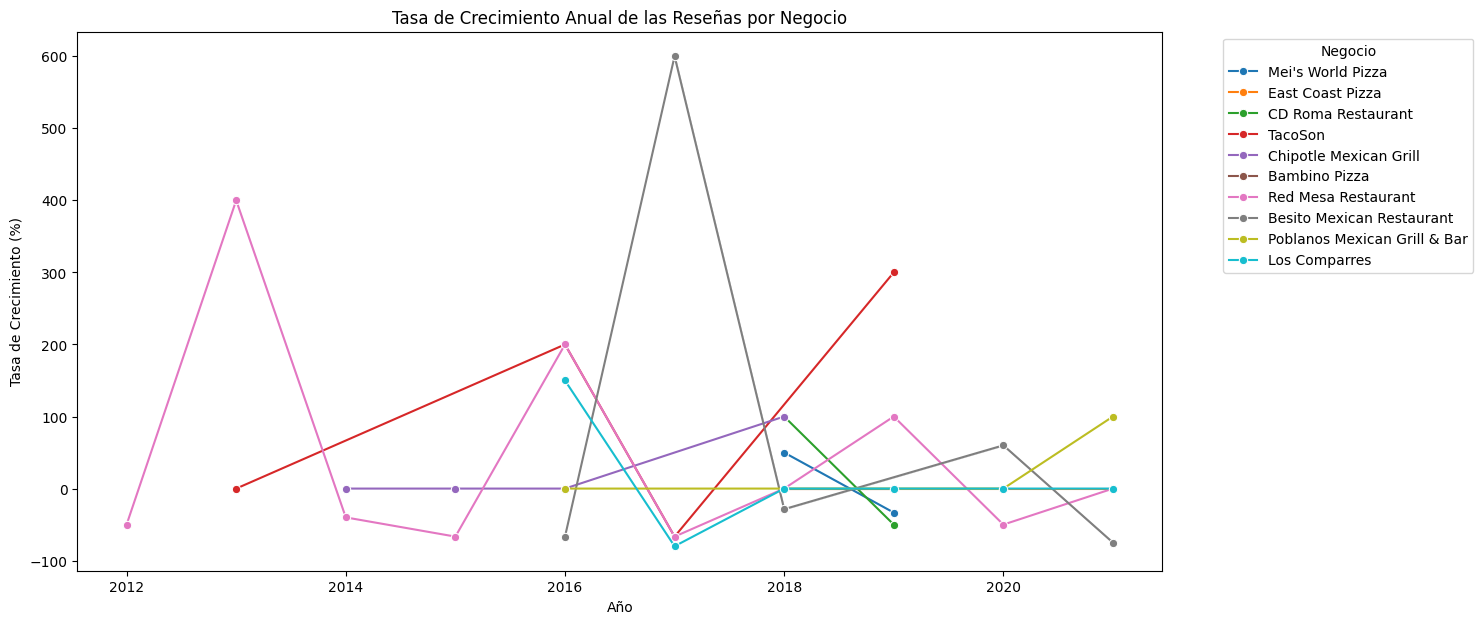

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar negocios específicos si es necesario para claridad en el gráfico
negocios_a_graficar = df_combinado['business_id'].unique()[:10]  # Graficar solo los primeros 10 negocios para claridad
df_filtrado = df_combinado[df_combinado['business_id'].isin(negocios_a_graficar)]

plt.figure(figsize=(14, 7))
sns.lineplot(data=df_filtrado, x='year', y='growth_rate', hue='name', marker='o')
plt.title('Tasa de Crecimiento Anual de las Reseñas por Negocio')
plt.xlabel('Año')
plt.ylabel('Tasa de Crecimiento (%)')
plt.legend(title='Negocio', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


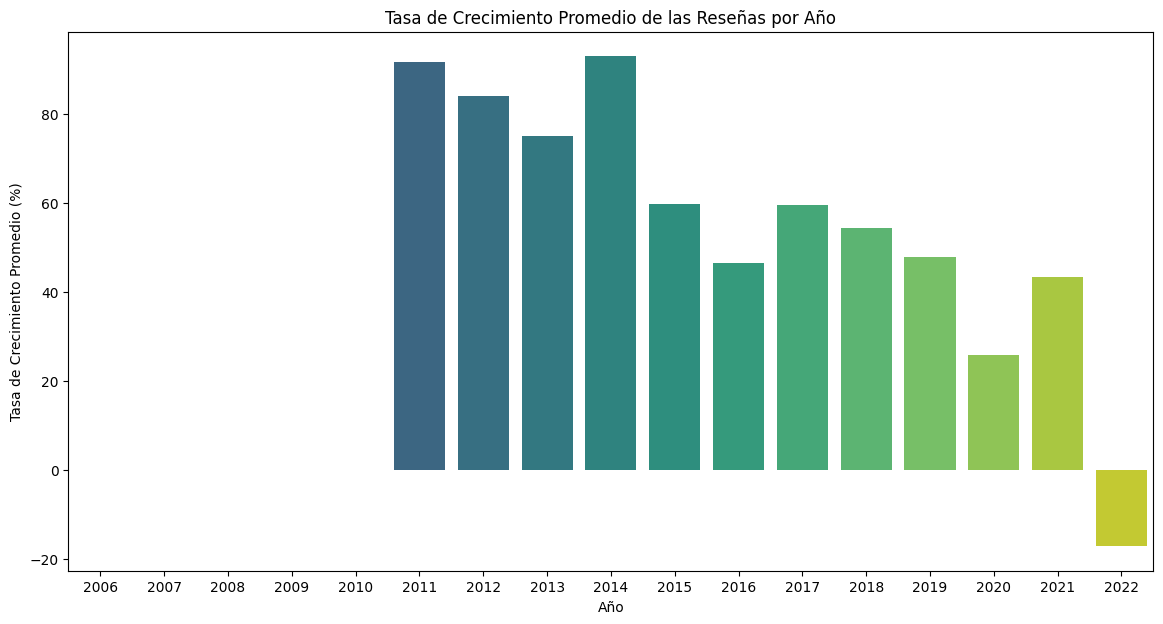

In [23]:
# Calcular la tasa de crecimiento promedio por año
df_promedio_crecimiento = df_combinado.groupby('year')['growth_rate'].mean().reset_index()

plt.figure(figsize=(14, 7))
sns.barplot(data=df_promedio_crecimiento, x='year', y='growth_rate', palette='viridis')
plt.title('Tasa de Crecimiento Promedio de las Reseñas por Año')
plt.xlabel('Año')
plt.ylabel('Tasa de Crecimiento Promedio (%)')
plt.show()


Código para predicción de crecimiento no funciona. No se cuenta con suficientes datos.

In [24]:
# Filtrar datos de un negocio específico
negocio_id = 'specific_business_id'  # Reemplaza con un business_id específico que esté en la lista impresa anteriormente
df_negocio = df_growth_rate[df_growth_rate['business_id'] == negocio_id].dropna(subset=['growth_rate'])

# Verificar si el DataFrame no está vacío
if df_negocio.empty:
    print(f"No hay datos disponibles para el business_id: {negocio_id}")
else:
    # Asegurarse de que los datos estén ordenados por fecha
    df_negocio = df_negocio.sort_values(by='year')

    # Seleccionar las columnas relevantes
    df_negocio_ts = df_negocio[['year', 'growth_rate']]
    df_negocio_ts.set_index('year', inplace=True)

    # Normalizar los datos
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    df_negocio_ts['growth_rate'] = scaler.fit_transform(df_negocio_ts[['growth_rate']])

    # Mostrar una muestra del dataframe de series temporales
    print(df_negocio_ts.head())

    # Visualizar los datos normalizados
    plt.figure(figsize=(12, 6))
    plt.plot(df_negocio_ts, marker='o')
    plt.title('Normalized Growth Rate Over Years')
    plt.xlabel('Year')
    plt.ylabel('Normalized Growth Rate')
    plt.show()

    # Verificar si hay valores nulos
    print(df_negocio_ts.isnull().sum())

    # Modelo ARIMA
    train_size = int(len(df_negocio_ts) * 0.8)
    train, test = df_negocio_ts.iloc[:train_size], df_negocio_ts.iloc[train_size:]

    arima_model = ARIMA(train, order=(1, 1, 1))
    arima_model_fit = arima_model.fit()

    arima_predictions = arima_model_fit.forecast(steps=len(test))

    arima_mae = sm.tools.eval_measures.meanabs(arima_predictions, test['growth_rate'])
    arima_rmse = sm.tools.eval_measures.rmse(arima_predictions, test['growth_rate'])

    print(f'ARIMA MAE: {arima_mae}')
    print(f'ARIMA RMSE: {arima_rmse}')

    plt.figure(figsize=(12, 6))
    plt.plot(train, label='Train')
    plt.plot(test, label='Test')
    plt.plot(test.index, arima_predictions, label='ARIMA Predictions')
    plt.legend()
    plt.title('ARIMA Model Predictions')
    plt.show()

    # Modelo Prophet
    df_prophet = df_negocio_ts.reset_index()
    df_prophet.columns = ['ds', 'y']

    # Verificar si hay valores nulos en df_prophet
    print(df_prophet.isnull().sum())

    # Eliminar filas con valores nulos
    df_prophet = df_prophet.dropna()

    # Dividir los datos en conjuntos de entrenamiento y prueba
    train_size = int(len(df_prophet) * 0.8)
    train, test = df_prophet.iloc[:train_size], df_prophet.iloc[train_size:]

    # Verificar si los conjuntos de entrenamiento y prueba tienen suficientes datos
    print(f'Tamaño del conjunto de entrenamiento: {len(train)}')
    print(f'Tamaño del conjunto de prueba: {len(test)}')

    if len(train) < 2 or len(test) < 2:
        print("No hay suficientes datos para entrenar el modelo Prophet")
    else:
        # Configurar el modelo Prophet sin estacionalidad
        prophet_model = Prophet()
        prophet_model.fit(train)

        future = prophet_model.make_future_dataframe(periods=len(test), freq='Y')
        forecast = prophet_model.predict(future)

        # Denormalizar las predicciones para interpretar mejor
        prophet_predictions = scaler.inverse_transform(forecast[['yhat']].iloc[-len(test):]).flatten()
        test_denorm = scaler.inverse_transform(test[['y']]).flatten()

        prophet_mae = sm.tools.eval_measures.meanabs(prophet_predictions, test_denorm)
        prophet_rmse = sm.tools.eval_measures.rmse(prophet_predictions, test_denorm)

        print(f'Prophet MAE: {prophet_mae}')
        print(f'Prophet RMSE: {prophet_rmse}')

        plt.figure(figsize=(12, 6))
        plt.plot(train['ds'], scaler.inverse_transform(train[['y']]), label='Train')
        plt.plot(test['ds'], test_denorm, label='Test')
        plt.plot(test['ds'], prophet_predictions, label='Prophet Predictions')
        plt.legend()
        plt.title('Prophet Model Predictions')
        plt.show()


No hay datos disponibles para el business_id: specific_business_id


In [32]:
import pandas as pd

# Cargar los archivos y realizar el merge
df_combinado = pd.read_parquet('df_combinado.parquet')
df_new = pd.read_csv('STAGED_Yelp_business_filtered_FL.csv')

# Realizar el merge basado en 'business_id' y 'name'
df_merged = pd.merge(df_new, df_combinado, on=['business_id', 'name'], how='left')

# Eliminar columnas duplicadas que no son necesarias
columns_to_drop = ['address_y', 'city_y', 'latitude_y', 'longitude_y', 'review_count_y', 'categories_y']
df_merged.drop(columns=columns_to_drop, inplace=True)

# Rellenar los espacios en blanco en las reseñas con texto similar
columns_to_fill = ['text', 'polarity', 'subjectivity', 'stars_x']
for column in columns_to_fill:
    df_merged[column] = df_merged[column].fillna(df_merged.groupby('name')[column].transform(lambda x: x.mode()[0] if not x.mode().empty else None))

# Llenar con un valor por defecto si no hay modo disponible
df_merged.fillna({'text': 'No review available', 'polarity': 0, 'subjectivity': 0.5, 'stars_x': df_merged['stars']}, inplace=True)

# Guardar el DataFrame df_merged en un archivo Parquet
df_merged.to_parquet('df_merged.parquet', index=False)

# Confirmar que el archivo se guardó correctamente
print("Archivo df_merged.parquet guardado correctamente.")



Archivo df_merged.parquet guardado correctamente.


In [35]:
# Definir las correcciones para los nombres de las ciudades
city_corrections = {
    'Saint Petersburg': 'St. Petersburg',
    'St Petersburg': 'St. Petersburg',
    'St Pete Beach': 'St. Pete Beach',
    'Saintt Petersburg': 'St. Petersburg',
    'Saint Pete Beach': 'St. Pete Beach',
    'Land O Lakes': 'Land O\' Lakes',
    'Wesley chapel': 'Wesley Chapel',
    'Lutz fl': 'Lutz',
    'Redingtn Shor': 'Redington Shores',
    'TEMPLE TERR': 'Temple Terrace',
    'Hernando Bch': 'Hernando Beach',
    'wimauma': 'Wimauma',
    'Largo (Walsingham)': 'Key Largo',
    'Largo': 'Key Largo',
    'Town N Country': 'Town \'n\' Country',
    'Town \'N\' Country': 'Town \'n\' Country',
    'Tampa Bay': 'Tampa',
    'Clearwater Beach': 'Clearwater',
    'Clearwater beach': 'Clearwater',
    'Pinecrest West Park': 'Pinecrest'
}

# Aplicar las correcciones al DataFrame
df_merged['city_x'] = df_merged['city_x'].replace(city_corrections)

# Verificar los valores únicos de las ciudades después de las correcciones
df_merged['city_x'].unique()

array(['Wesley Chapel', 'Oldsmar', 'St. Petersburg', 'Tampa',
       'Spring Hill', 'Clearwater', 'Holiday', 'Lutz', 'Valrico',
       'Hudson', 'New Port Richey', 'Palm Harbor', 'Trinity', 'Brandon',
       'Key Largo', 'Port Richey', 'Madeira Beach', 'Odessa', 'Riverview',
       'Pinellas Park', 'Plant City', 'Indian Rocks Beach', 'Dunedin',
       'Seminole', 'Tarpon Springs', 'Seffner', 'Temple Terrace',
       'Zephyrhills', 'St. Pete Beach', 'Apollo Beach', 'Sun City Center',
       'Tierra Verde', 'South Pasadena', "Land O' Lakes", 'Safety Harbor',
       'Lithia', 'Ruskin', 'Indian Shores', 'Belleair Bluffs',
       'Gibsonton', 'Redington Shores', 'Wimauma', 'Gulfport',
       'North Redington Beach', 'Kenneth City', 'Palmetto',
       'Treasure Island', 'Citrus Park', "Town 'n' Country",
       'San Antonio', 'Thonotosassa', 'Hernando Beach'], dtype=object)

In [36]:
# Guardar el DataFrame df_merged en un archivo Parquet
df_merged.to_parquet('df_merged.parquet', index=False)

# Confirmar que el archivo se guardó correctamente
print("Archivo df_merged.parquet guardado correctamente.")

Archivo df_merged.parquet guardado correctamente.
